In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir("../")

In [114]:
from data_processing.start_experiment import *
from data_processing.read_data import *
from data_processing.gaussian import *

In [159]:
import matplotlib.pyplot as plt
import numpy as np
from emukit.core import ParameterSpace, ContinuousParameter, DiscreteParameter
from emukit.core.initial_designs import RandomDesign
from emukit.core.initial_designs.latin_design import LatinDesign
from GPy.models import GPRegression
from emukit.model_wrappers import GPyModelWrapper
import GPy
from emukit.sensitivity.monte_carlo import MonteCarloSensitivity
import time
import random
from sklearn import tree
from emukit.quadrature.methods import VanillaBayesianQuadrature
from emukit.quadrature.loop import VanillaBayesianQuadratureLoop


In [5]:
num_experiments = 100
parameter_list = ['season_duration', 'gamma', 'mut_rate', 'T', 'target_area', 'gradnoise']
parameter_space = ParameterSpace([DiscreteParameter('season_duration',list(range(100,1001,10))), 
                                 DiscreteParameter('gamma',list(range(0,25))), 
                                 ContinuousParameter('mut_rate',0,0.5),
                                 ContinuousParameter('T',1,100),
                                 DiscreteParameter('target_area',list(range(1,101))),
                                 ContinuousParameter('gradnoise',0.25,0.99)])

In [6]:
file_names = ["latin/latin_{}.par".format(i) for i in range(num_experiments)]
data_files = ["latin/data_cellcount_{}.txt".format(i) for i in range(num_experiments)]

In [7]:
X = get_parameter_array(file_names,parameter_list)

# Some files have no data; don't get those
unrun_files = get_no_data(data_files) 
X_no_data = X[unrun_files,:]

X = np.delete(X,unrun_files,axis=0)

In [8]:
all_data = [read_data(file_name) for i,file_name in enumerate(data_files) if i not in unrun_files]

In [9]:
def plot(num,func):
    all_times = sorted(set([i.time for i in all_data[num]]))
        
    x = []
    y = []
    
    for i in all_times:
        x.append(i)
        y.append(func(all_data[num],i))
        
    plt.plot(x,y)
    

In [10]:
Y = get_rewards(data_files,lambda s: len(s))

In [27]:
run_to_completion = Y>5000

In [12]:
X_full, Y_full = X[run_to_completion.flatten(),:], Y[run_to_completion.flatten()]

In [13]:
X_full[0,:] = np.lcm(X_full[0,:].astype(int),25)

In [14]:
data_full = [data for i,data in enumerate(all_data) if run_to_completion[i,0] == True]

In [15]:
num_blob_data = [[num_blobs_cells(data,j) for j in range(0,50000,1000)] for data in data_full]

In [16]:
num_blob_data = np.array(num_blob_data)

In [17]:
num_blob_data.shape

(75, 50)

# 1. Decision Tree; what are the most important values

In [18]:
X_tree = X_full
Y_tree = num_blob_data[:,0].reshape(len(num_blob_data),1)

In [19]:
clf = tree.DecisionTreeClassifier()
clf.fit(X_tree,Y_tree)

DecisionTreeClassifier()

In [20]:
clf.feature_importances_

array([0.07077735, 0.5165547 , 0.03598848, 0.        , 0.22792706,
       0.1487524 ])

In [24]:
Y_tree_rounded = np.digitize(Y_tree,[0,20,100])
clf = tree.DecisionTreeClassifier()
clf.fit(X_tree,Y_tree_rounded)

DecisionTreeClassifier()

[Text(334.8, 543.6, 'X[1] <= 5.5\ngini = 0.353\nsamples = 75\nvalue = [4, 12, 59]'),
 Text(167.4, 326.16, 'X[4] <= 51.0\ngini = 0.32\nsamples = 15\nvalue = [3, 12, 0]'),
 Text(83.7, 108.72000000000003, 'gini = 0.0\nsamples = 3\nvalue = [3, 0, 0]'),
 Text(251.10000000000002, 108.72000000000003, 'gini = 0.0\nsamples = 12\nvalue = [0, 12, 0]'),
 Text(502.20000000000005, 326.16, 'X[5] <= 0.127\ngini = 0.033\nsamples = 60\nvalue = [1, 0, 59]'),
 Text(418.5, 108.72000000000003, 'gini = 0.0\nsamples = 1\nvalue = [1, 0, 0]'),
 Text(585.9, 108.72000000000003, 'gini = 0.0\nsamples = 59\nvalue = [0, 0, 59]')]

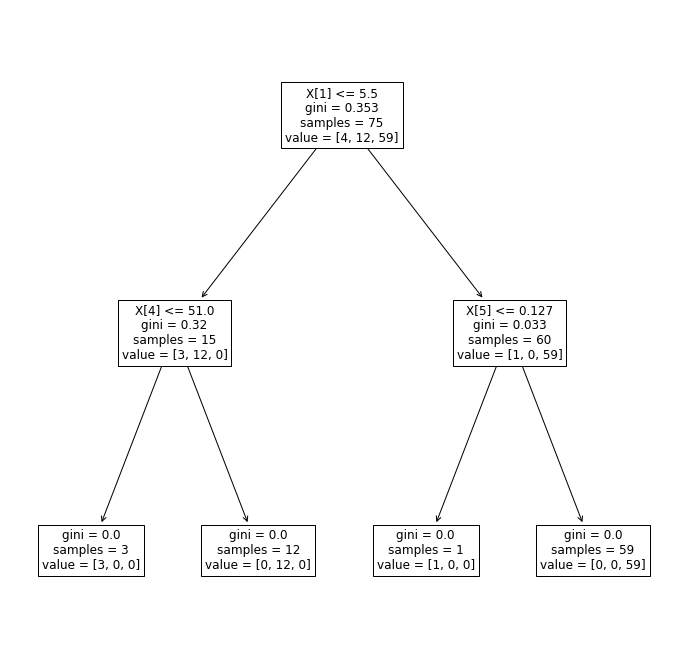

In [25]:
plt.figure(figsize=(12,12))
tree.plot_tree(clf,fontsize=12)

In [47]:
Y_tree = num_blob_data[:,-1].reshape(len(num_blob_data),1)
Y_tree_rounded = np.digitize(Y_tree,[50])
clf = tree.DecisionTreeClassifier()
clf.fit(X_tree,Y_tree_rounded)

DecisionTreeClassifier()

In [144]:
clf.feature_importances_

array([0.14338338, 0.0922445 , 0.17745513, 0.23370518, 0.32280119,
       0.03041062])

[Text(313.875, 611.5500000000001, 'X[3] <= 54.46\ngini = 0.365\nsamples = 75\nvalue = [18, 57]'),
 Text(167.4, 530.01, 'X[2] <= 0.145\ngini = 0.48\nsamples = 40\nvalue = [16, 24]'),
 Text(125.55000000000001, 448.47, 'gini = 0.0\nsamples = 11\nvalue = [0, 11]'),
 Text(209.25, 448.47, 'X[4] <= 50.0\ngini = 0.495\nsamples = 29\nvalue = [16, 13]'),
 Text(167.4, 366.93, 'gini = 0.0\nsamples = 8\nvalue = [0, 8]'),
 Text(251.10000000000002, 366.93, 'X[0] <= 705.0\ngini = 0.363\nsamples = 21\nvalue = [16, 5]'),
 Text(167.4, 285.39000000000004, 'X[3] <= 22.78\ngini = 0.208\nsamples = 17\nvalue = [15, 2]'),
 Text(125.55000000000001, 203.85000000000002, 'X[1] <= 11.5\ngini = 0.408\nsamples = 7\nvalue = [5, 2]'),
 Text(83.7, 122.31000000000006, 'X[3] <= 9.415\ngini = 0.444\nsamples = 3\nvalue = [1, 2]'),
 Text(41.85, 40.76999999999998, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(125.55000000000001, 40.76999999999998, 'gini = 0.0\nsamples = 2\nvalue = [0, 2]'),
 Text(167.4, 122.31000000000006

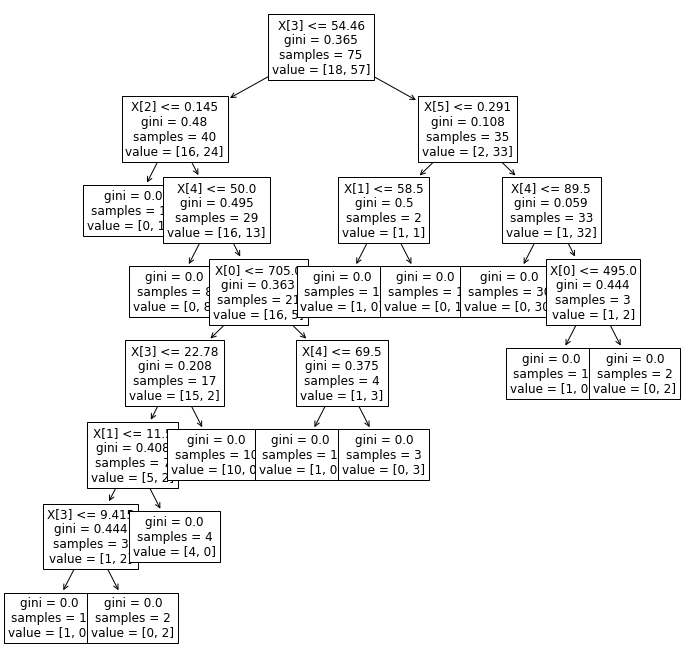

In [48]:
plt.figure(figsize=(12,12))
tree.plot_tree(clf,fontsize=12)

Initial multicellularity is largely based on cell-based parameters, particularly the gamma parameter, and the cell size, both of which dictate how close together they initial huddle together. However, after time persists, the dominant factors in how multicellularity persists are the environmental factors. Temperature is the top factor in the decision tree; if the temperature is large, then particles are too "jumpy" to stick together, and so large temperature lead to large numbers of blobs. Cell factors still play a role, such as having a large enough cell size to encourage contact, and a large enough mutation rate that adhesion is encouraged

# 2. Identify correlations between initial and final multicellularity

In [28]:
Y_initial = num_blob_data[:,0].reshape(len(num_blob_data))
Y_final = num_blob_data[:,-1].reshape(len(num_blob_data))

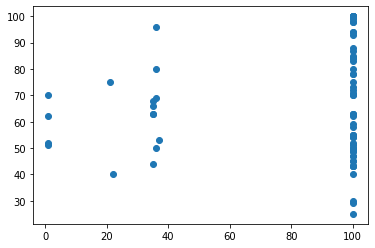

In [29]:
plt.scatter(Y_initial,Y_final)

In [50]:
np.corrcoef(Y_initial,Y_final)

array([[1.        , 0.09281665],
       [0.09281665, 1.        ]])

(array([ 4.,  0.,  2., 10.,  0.,  0.,  0.,  0.,  0., 59.]),
 array([  1. ,  10.9,  20.8,  30.7,  40.6,  50.5,  60.4,  70.3,  80.2,
         90.1, 100. ]),
 <BarContainer object of 10 artists>)

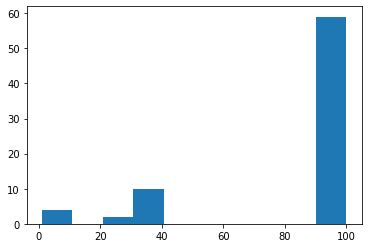

In [52]:
plt.hist(Y_initial)

(0.0, 60.0)

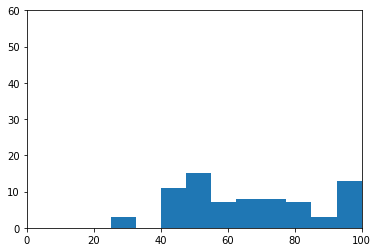

In [55]:
plt.hist(Y_final)
plt.xlim([0,100])
plt.ylim([0,60])

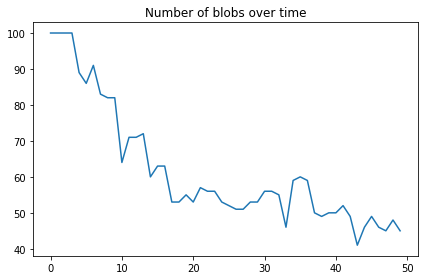

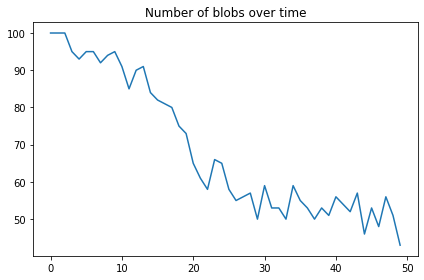

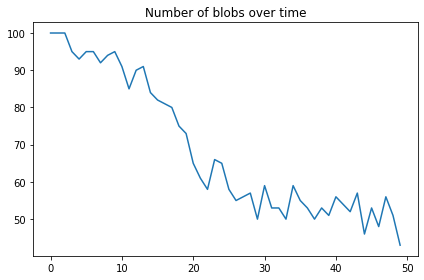

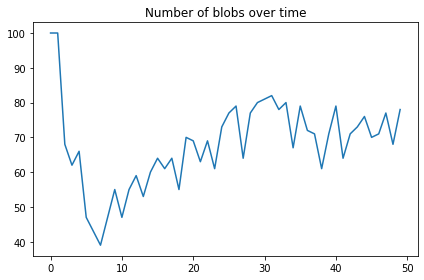

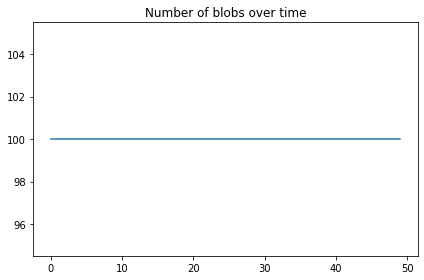

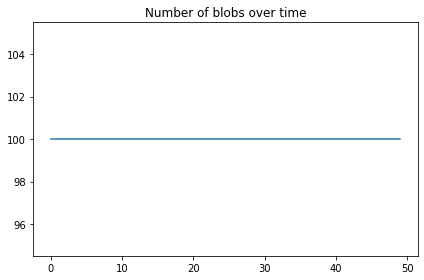

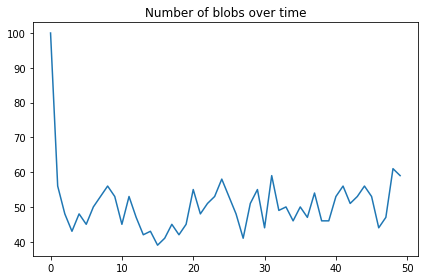

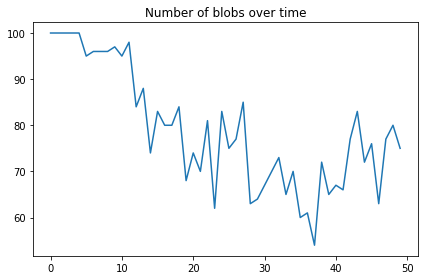

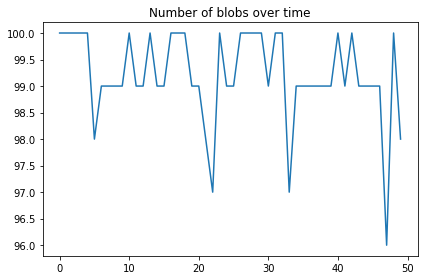

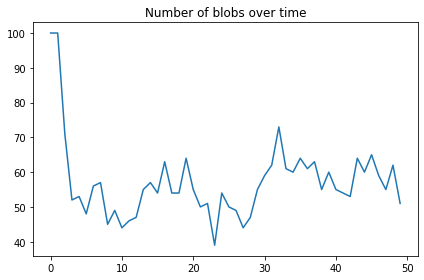

<Figure size 432x288 with 0 Axes>

In [51]:
for i in range(10):
    plt.title("Number of blobs over time")
    index = random.randint(0,len(num_blob_data)-1)
    plt.plot(list(range(len(num_blob_data[index]))),num_blob_data[index])
    plt.tight_layout()
    plt.figure()

We see that initial settings are not soley responsible for the propogation of multicellularity. For different simulations which start with 100 blobs (all cells indepdent), we see that, depending on the celllar and environmental conditions, they tend to break off into different strata. Some simulations start with a sharp increase in multicellularity, followed by a levelling off, while others tend to remain unicellular throughout. In general, many simulations tend towards a degree of multicellularity, which is seen through the two histograms

# 3. Train a GP to predict final or initial multicellularity

In [184]:
kernel = GPy.kern.RBF(input_dim=6, ARD=True, lengthscale=[10,5,0.1,10,10,0.05], variance=1)
model_gpy = GPRegression(X_full, Y_final.reshape((len(Y_final),1)) ,kernel = kernel,normalizer=True,noise_var=10)
model_emukit = GPyModelWrapper(model_gpy)
model_emukit.optimize()

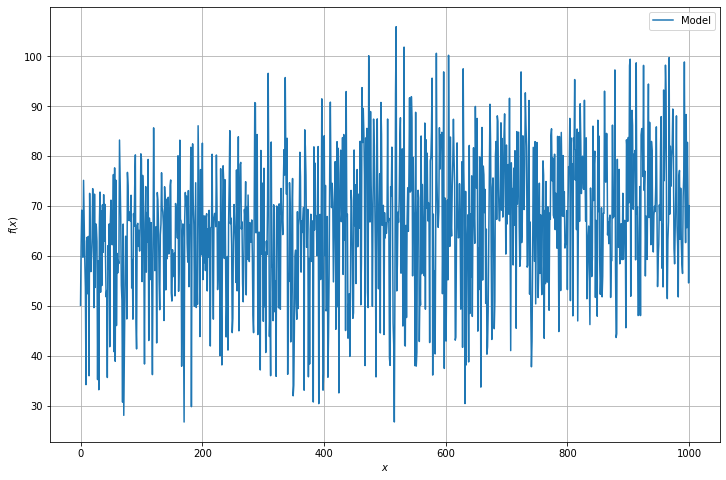

In [185]:
plot_gaussian_process(np.linspace(0,1000,1000),0,parameter_space,model_emukit)

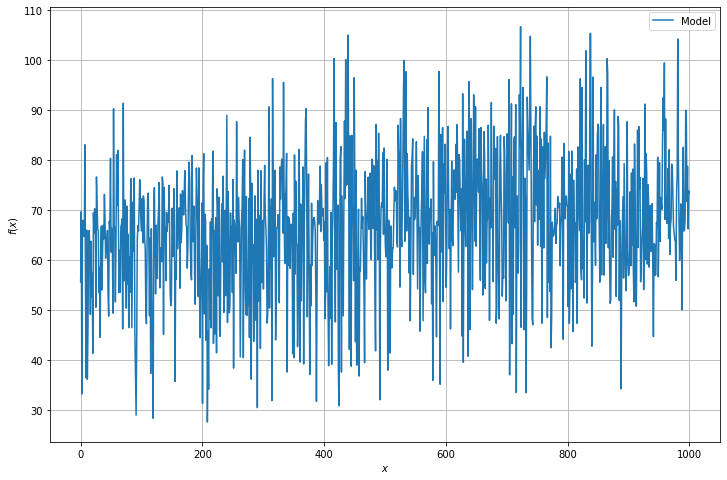

<Figure size 432x288 with 0 Axes>

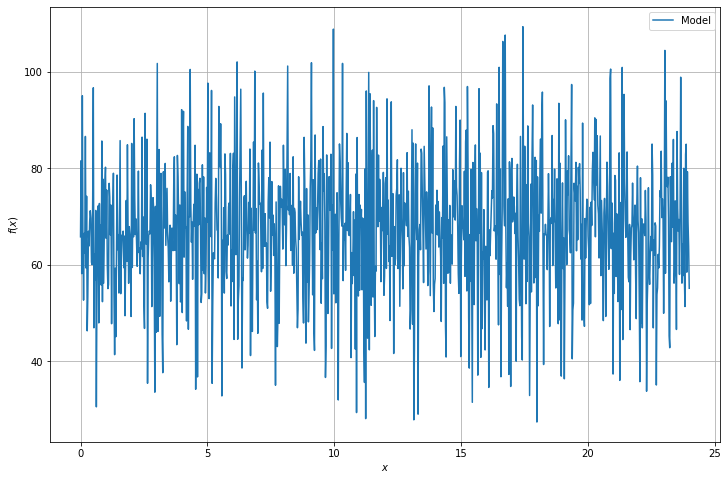

<Figure size 432x288 with 0 Axes>

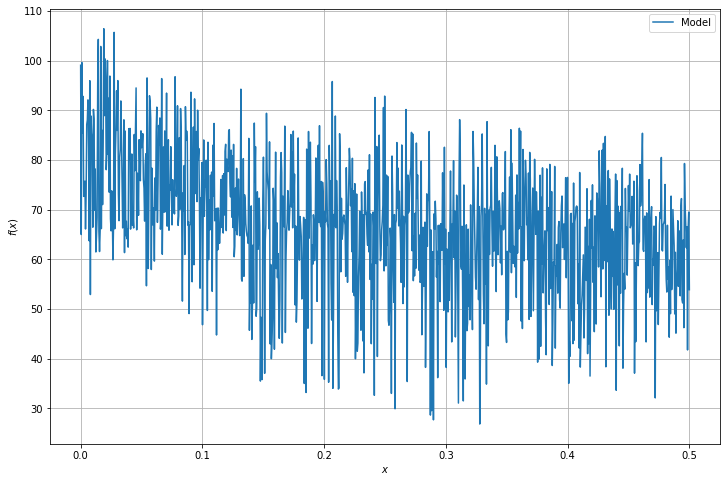

<Figure size 432x288 with 0 Axes>

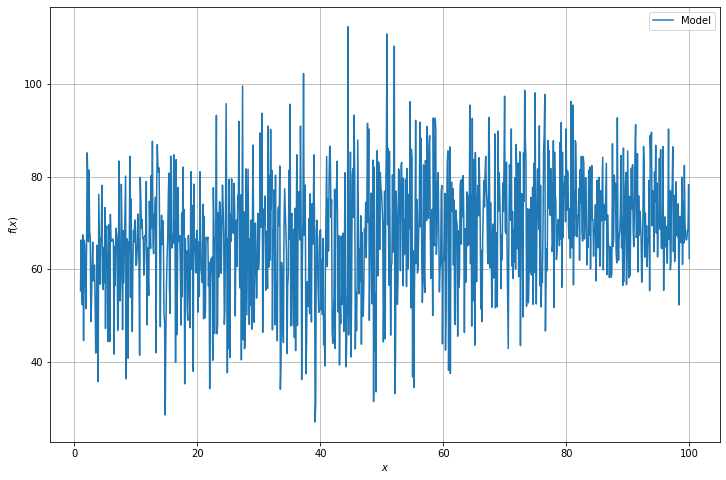

<Figure size 432x288 with 0 Axes>

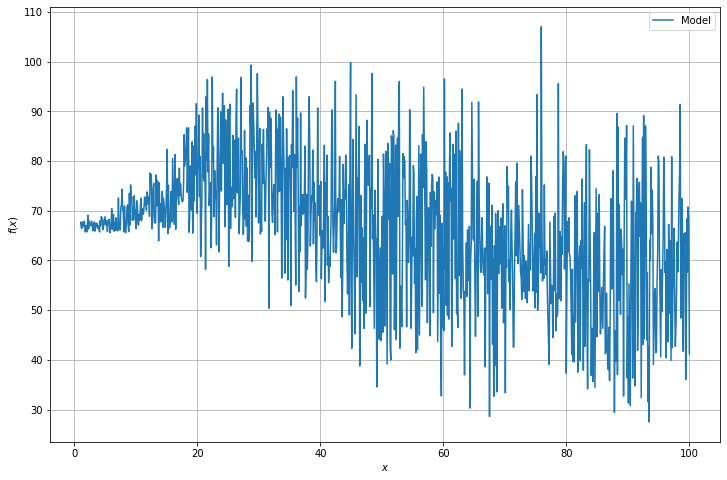

<Figure size 432x288 with 0 Axes>

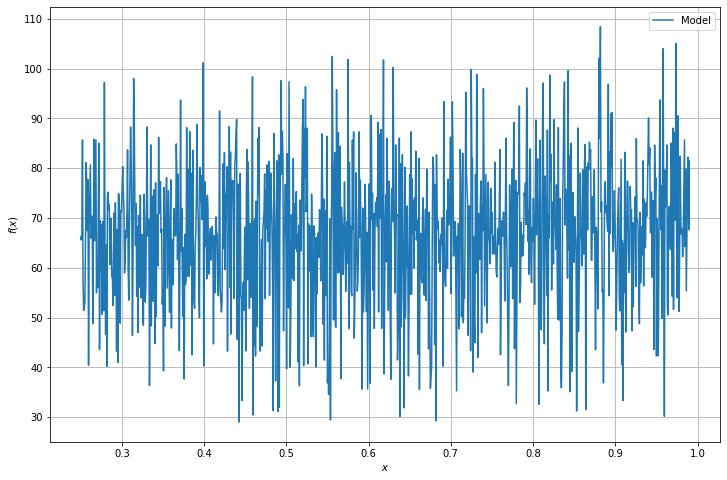

<Figure size 432x288 with 0 Axes>

In [192]:
ranges = [[0,1000],
         [0,24],
         [0,0.5],
         [1,100],
         [1,100],
         [0.25,0.99]]

for i in range(6):
    plot_gaussian_process(np.linspace(ranges[i][0],ranges[i][1],1000),i,parameter_space,model_emukit)
    plt.figure()


In [156]:
get_sobol_indices(model_emukit,parameter_space)

({'season_duration': array([135.49303125]),
  'gamma': array([142.36612018]),
  'mut_rate': array([130.92681717]),
  'T': array([144.57573629]),
  'target_area': array([136.83609864]),
  'gradnoise': array([130.98562032])},
 {'season_duration': array([-121.76763327]),
  'gamma': array([-128.64517989]),
  'mut_rate': array([-117.60409474]),
  'T': array([-130.85032777]),
  'target_area': array([-123.11626547]),
  'gradnoise': array([-117.65190432])})

In [153]:
kernel = GPy.kern.Matern52(input_dim=6)
model_gpy = GPRegression(X_full, Y_final.reshape((len(Y_final),1)) ,kernel = kernel,normalizer=True,noise_var=1)
model_emukit = GPyModelWrapper(model_gpy)
model_emukit.optimize()

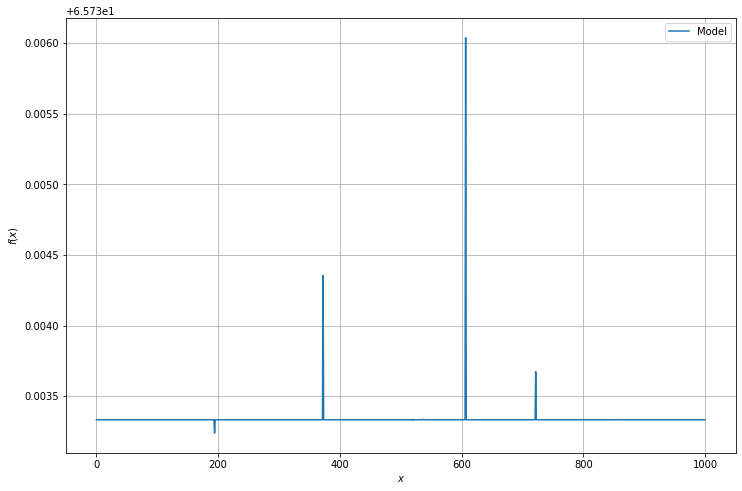

In [154]:
plot_gaussian_process(np.linspace(0,1000,1000),0,parameter_space,model_emukit)

In [155]:
get_sobol_indices(model_emukit,parameter_space)

({'season_duration': array([16453.21435839]),
  'gamma': array([16821.13243138]),
  'mut_rate': array([16760.66838095]),
  'T': array([15531.73455184]),
  'target_area': array([16534.92559307]),
  'gradnoise': array([16692.39434448])},
 {'season_duration': array([-16407.60664852]),
  'gamma': array([-16781.69072367]),
  'mut_rate': array([-16760.26662806]),
  'T': array([-15486.18368297]),
  'target_area': array([-16504.56429661]),
  'gradnoise': array([-16690.25240511])})

# 4. Find the location of the peak multicellularity

In [179]:
from emukit.quadrature.kernels import QuadratureRBF
from emukit.model_wrappers.gpy_quadrature_wrappers import RBFGPy, BaseGaussianProcessGPy

emukit_rbf = RBFGPy(kernel)
emukit_qrbf = QuadratureRBF(emukit_rbf,variable_names=parameter_list)
emukit_model = BaseGaussianProcessGPy(kern=emukit_qrbf, gpy_model=model_emukit)

TypeError: __init__() missing 1 required positional argument: 'measure'

In [172]:
emukit_method = VanillaBayesianQuadrature(base_gp=model_emukit,X=X_full, Y=Y_final.reshape((len(Y_final),1)))

In [169]:
emukit_method = VanillaBayesianQuadrature(base_gp=model_gpy, 
emukit_loop = VanillaBayesianQuadratureLoop(model=emukit_method)

AttributeError: 'GPRegression' object has no attribute 'set_data'

In [158]:
height_of_peak_estimate, height_of_peak_variance = model_emukit.model.integrate()

AttributeError: 'GPRegression' object has no attribute 'integrate'

# 5. Bayesian Optimization